<a href="https://colab.research.google.com/github/haooooooqi/visualization/blob/main/video_mae_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Masked Autoencoders: Visualization Demo

This is a visualization demo using our pre-trained MAE models. No GPU is needed.

### Prepare
Check environment. Install packages if in Colab.


In [2]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !pip3 install opencv3
    !pip3 install simplejson
    !pip3 install matplotlib
    !pip3 install iopath
    !pip install common
    !pip install fvcore
    !pip install av
    !rm -rf visualization mae
    !git clone https://github.com/haooooooqi/visualization.git
    !mv visualization mae
    sys.path.append('./mae')
    !rm -rf slowfast SlowFast
    !git clone https://github.com/facebookresearch/SlowFast.git
    !mv SlowFast slowfast
    sys.path.append('./slowfast')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
     |████████████████████████████████| 287 kB 8.2 MB/s 
ERROR: Could not find a version that satisfies the requirement opencv3 (from versions: none)
ERROR: No matching distribution found for opencv3
     |████████████████████████████████| 130 kB 10.5 MB/s 
  Created wheel for common: filename=common-0.1.2-py3-none-any.whl size=3732 sha256=60d2d55cabce746d16e4b52f205c406a0bc93bd8a1ae0384d7f1965c992279f1
  Stored in directory: /root/.cache/pip/wheels/11/88/ea/416ddc295a285f3661c88772a64b4a3766a92ce55f7b01dd9d
Successfully built common
     |████████████████████████████████| 50 kB 3.8 MB/s 
     |████████████████████████████████| 596 kB 22.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220414-py3-none-any.whl size=61211 sha256=2e54dcd55ff33c882e2c599152f22a51e638f4c44a4f25ac4d4e0a98883ea9d6
  Stored in directory: /root/.cache/pip/wheels/df/f4/b8/7b5df8b6722f4c72315ce70c31aa693e00cef6a5056149bd28
Successfully built fvcore
  Attempting uninstall: pyyaml
 

### Define utils

In [3]:
from slowfast.datasets.decoder import pyav_decode, temporal_sampling
from mae.util.decoder.utils import tensor_normalize, spatial_sampling
import av


MEAN = (0.45, 0.45, 0.45)
STD = (0.225, 0.225, 0.225)
DEMO_PATH = "mae/demo/qZ_lFjCiR1c_000104_000114.avi"

def prepare_video(path):
    video_container = av.open(path)
    frames, _, _ = pyav_decode(
        video_container,
        4,
        16,
        5,
        num_clips_uniform=10,
        target_fps=30,
        use_offset=False,
    )
    frames = temporal_sampling(frames, 0, 64, 16)
    frames = tensor_normalize(
        frames, 
        torch.tensor(MEAN), 
        torch.tensor(STD),
    ).permute(3, 0, 1, 2)
    frames = spatial_sampling(
        frames,
        spatial_idx=1,
        min_scale=256,
        max_scale=256,
        crop_size=224,
        random_horizontal_flip=False,
        inverse_uniform_sampling=False,
    )
    frames = spatial_sampling(
        frames,
        spatial_idx=1,
        min_scale=256,
        max_scale=256,
        crop_size=224,
        random_horizontal_flip=False,
        inverse_uniform_sampling=False,
        aspect_ratio=None,
        scale=None,
        motion_shift=False,
    )
    return frames

Please update your PyTorchVideo to latest master


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  "The _functional_video module is deprecated. Please use the functional module instead."
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/_transforms_video.py:26: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  "The _transforms_video module is deprecated. Please use the transforms module instead."


In [4]:
vid = prepare_video(DEMO_PATH)

In [5]:
def plot_input(tensor):
    tensor = tensor.float()
    f, ax = plt.subplots(nrows=tensor.shape[0], ncols=tensor.shape[1], figsize=(50, 20))

    tensor = tensor * torch.tensor(STD).view(3, 1, 1)
    tensor = tensor + torch.tensor(MEAN).view(3, 1, 1)
    tensor = torch.clip(tensor * 255, 0, 255).int()

    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax[i][j].axis("off")
            ax[i][j].imshow(tensor[i][j].permute(1, 2, 0))
    plt.show()

In [8]:
from mae.models_mae import mae_vit_large_patch16
model = mae_vit_large_patch16(decoder_embed_dim=512, decoder_depth=4, mask_type="st", t_patch_size=2)

img_size (224, 224) patch_size (16, 16) frames 16 t_patch_size 2
==== num_patches 1568
model initialized


In [1]:
!wget 'https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth' -O checkpoint.pth

--2022-04-24 20:33:28--  https://dl.fbaipublicfiles.com/video-mae-100x4-joint.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3823763371 (3.6G) [binary/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>]   3.56G  60.0MB/s    in 64s     

2022-04-24 20:34:32 (57.0 MB/s) - ‘checkpoint.pth’ saved [3823763371/3823763371]



In [9]:
checkpoint = torch.load("./checkpoint.pth", map_location='cpu')
msg = model.load_state_dict(checkpoint['model'], strict=False)
print(msg)

<All keys matched successfully>


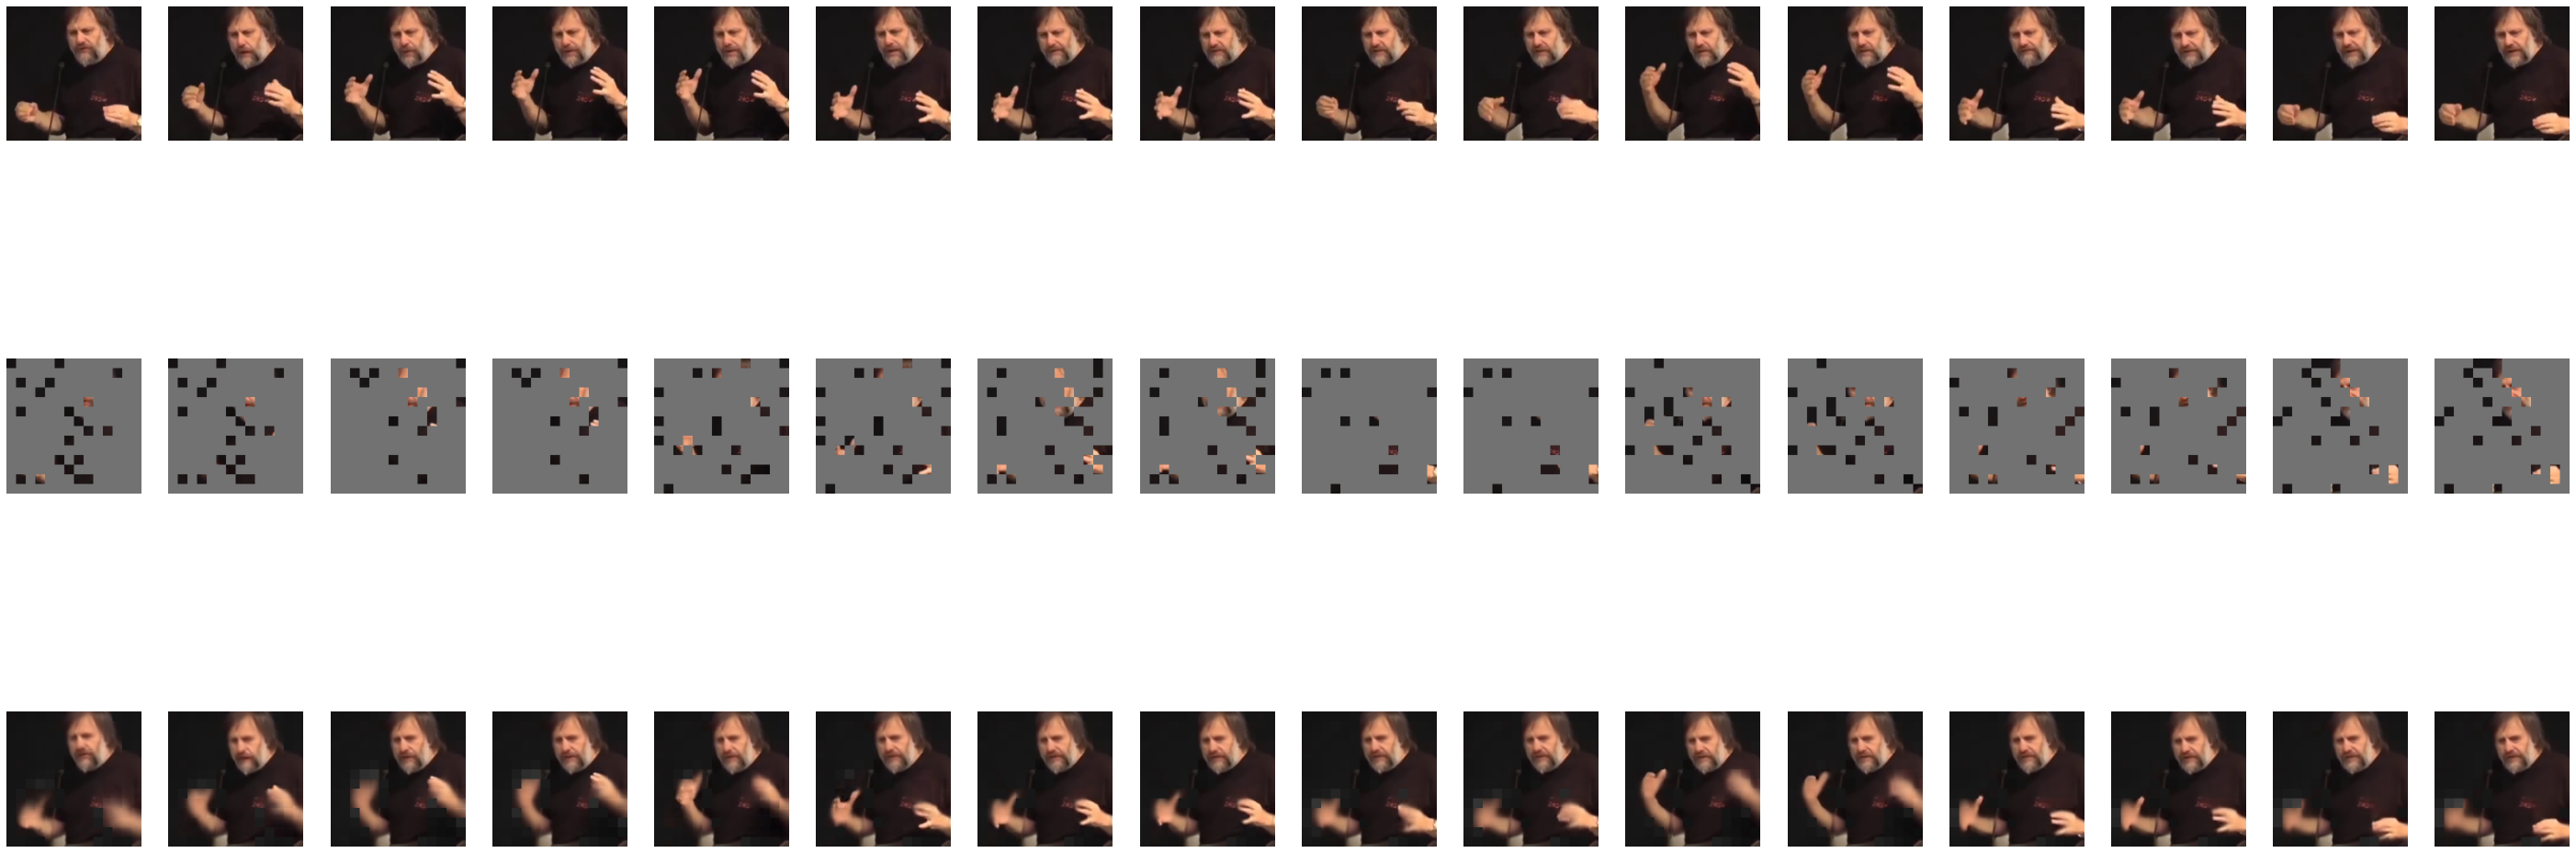

In [10]:
_, _, _, vis = model(vid.unsqueeze(0), 1, mask_ratio=0.9, visualize=True)
plot_input(vis[0].permute(0, 2, 1, 3, 4))

In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  print(f.read())


# https://drive.google.com/file/d/1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m/view?usp=sharing

NameError: ignored

In [2]:
file_list

[]

In [4]:
!wget file.csv 'https://docs.google.com/uc?export=download&id=1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m&confirm=t' -O checkpoint.pth

--2022-04-24 06:12:48--  http://file.csv/
Resolving file.csv (file.csv)... failed: Name or service not known.
wget: unable to resolve host address ‘file.csv’
--2022-04-24 06:12:48--  https://docs.google.com/uc?export=download&id=1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m&confirm=t
Resolving docs.google.com (docs.google.com)... 173.194.211.101, 173.194.211.139, 173.194.211.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.211.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pp3832fc3tap3mdkh1oa1f77a9dq9ikb/1650780750000/08709503585562668116/*/1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m?e=download [following]
--2022-04-24 06:12:48--  https://doc-10-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pp3832fc3tap3mdkh1oa1f77a9dq9ikb/1650780750000/08709503585562668116/*/1bBaEH42uS3kBVLbpVQ0vki2i8CSYR31m?e=download
Resolving doc-10-b0-docs.go